In [21]:
import numpy as np
from vivarium import Vivarium
from spatio_flux import PROCESS_DICT, TYPES_DICT, build_path, render_path

In [22]:
# TODO -- make a spatio-flux specific Vivarium with the the core preloaded
v = Vivarium(processes=PROCESS_DICT, types=TYPES_DICT)

In [23]:
v.get_types()

['',
 'protocol',
 'length^2',
 'length/time',
 'length^4*mass/current*time^3',
 'kinetics',
 'time/length',
 'length/mass',
 'length/time^2',
 'length^2*mass/temperature*time^2',
 'float',
 'wires',
 'length^2*mass/time',
 'maybe',
 'mass/length*time',
 'substrate_role',
 'substance/length^3',
 'bounds',
 'temperature',
 'string',
 'length^2*mass/current*time^2',
 'edge',
 'map',
 'length^2*mass/substance*temperature*time^2',
 'length^0_5*mass^0_5/time',
 'luminosity',
 'list',
 'printing_unit',
 '/temperature*time',
 'union',
 'length^3/mass*time^2',
 'any',
 'length^2*mass/current*time^3',
 'process',
 'mass^0_5/length^0_5*time',
 'substance/time',
 'time^2/length',
 'positive_float',
 '/time',
 'luminosity/length^2',
 'tuple',
 'length*time/mass',
 'current*length*time',
 'length*mass/current*time^3',
 'current^2*time^4/length^3*mass',
 'length',
 'current^2*time^4/length^2*mass',
 'current^2*time^3/length^2*mass',
 'mass/time^3',
 'mass^0_5/length^1_5',
 'length^3*mass/current^2*t

In [24]:
# view the available processes
v.get_processes()

['MinimalParticle',
 'DynamicFBA',
 'DiffusionAdvection',
 'json-emitter',
 'console-emitter',
 'Particles',
 'composite',
 'ram-emitter']

## dFBA alone

In [25]:
# inspect the config schema for the 'increase' process
v.process_config('DynamicFBA')

{'model_file': 'string',
 'kinetic_params': 'map[tuple[float,float]]',
 'substrate_update_reactions': 'map[string]',
 'biomass_identifier': 'string',
 'bounds': 'map[bounds]'}

In [26]:
dfba_config  = v.process_config('DynamicFBA', dataclass=True)  # TODO -- make this work

Error finding process DynamicFBA: 'type_parameters'


In [27]:
# TODO - enable get_dataclass to work with the new process
# dfba_config  = v.get_dataclass('DynamicFBA')
dfba_config = {
    "model_file": "textbook",
    "kinetic_params": {
        "glucose": (0.5, 1),
        "acetate": (0.5, 2)},
    "substrate_update_reactions": {
        "glucose": "EX_glc__D_e",
        "acetate": "EX_ac_e"},
    "biomass_identifier": "biomass",
    "bounds": {
        "EX_o2_e": {"lower": -2, "upper": None},
        "ATPM": {"lower": 1, "upper": 1}
    }
}

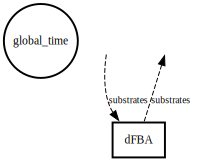

In [28]:
# add a dynamic FBA process called 'dFBA'
v.add_process(name="dFBA",
              process_id="DynamicFBA",
              config=dfba_config,
              )
v.diagram(dpi='70')

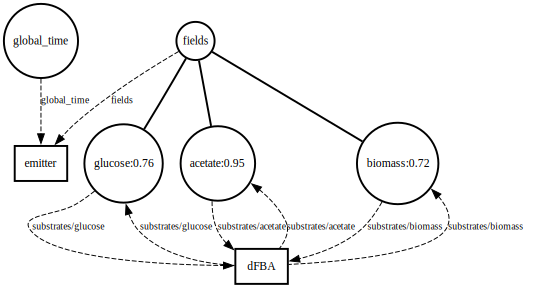

In [29]:
mol_ids = ["glucose", "acetate", "biomass"]
path=["fields"]

for mol_id in mol_ids:
    v.add_object(
        name=mol_id,
        path=path,
        value=np.random.rand()
    )

v.connect_process(
    process_name="dFBA",
    inputs={
            "substrates": {
                mol_id: build_path(path, mol_id)
                for mol_id in mol_ids}
        },
    outputs={
            "substrates": {
                mol_id: build_path(path, mol_id)
                for mol_id in mol_ids}
        }
)

# add an emitter to save results
v.add_emitter()

# TODO -- show_values does not work
v.diagram(dpi='70', show_values=True)

In [30]:
v.set_value(path = ['fields', 'glucose'], value=10)
v.set_value(path = ['fields', 'biomass'], value=0.1)
field = v.get_value(['fields'])
print(field)

{'glucose': 10, 'acetate': 0.9497510412562499, 'biomass': 0.1}


In [31]:
# run the simulation for 10 time units
v.run(interval=60)

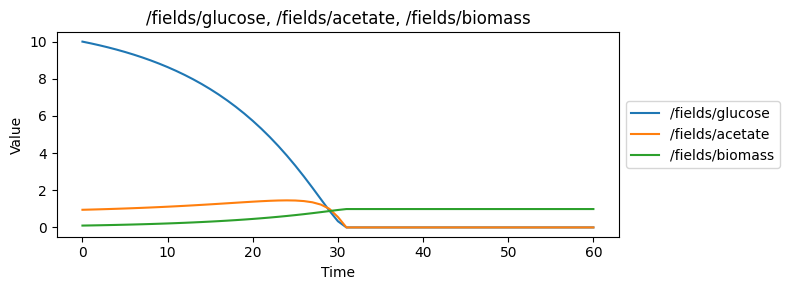

In [32]:
v.plot_timeseries(
    subplot_size=(8, 3),
    combined_vars=[
        [
            '/fields/glucose',
            '/fields/acetate',
            '/fields/biomass'
        ]
    ]
)

## Spatial Dynamic FBA

Adding dFBA[0,0] to ['fields', 'mol_id', 0, 0]

Adding dFBA[1,0] to ['fields', 'mol_id', 1, 0]



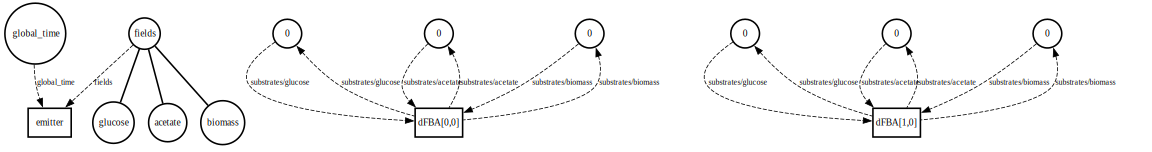

In [33]:
mol_ids = ["glucose", "acetate", "biomass"]
path=["fields"]
rows = 2
columns = 1

# make the vivarium
v2 = Vivarium(processes=PROCESS_DICT, types=TYPES_DICT)
for mol_id in mol_ids:
    v2.add_object(
        name=mol_id,
        path=path,
        # type='array',
        value=np.random.rand(rows, columns)
    )

# add a dynamic FBA process at every location
for i in range(rows):
    for j in range(columns):

        dfba_name = f"dFBA[{i},{j}]"
        path_name = build_path(path, 'mol_id', i, j)
        print(f'Adding {dfba_name} to {path_name}\n')

        rewire_path= path  # [".."] + path

        # add a process for this location
        v2.add_process(
            name=dfba_name,
            process_id="DynamicFBA",
            # path=['species'],
            config=dfba_config,
        )
        v2.connect_process(
            process_name=dfba_name,
            # path=['species'],
            inputs={
                    "substrates": {
                        mol_id: build_path(rewire_path, mol_id, i, j)
                        for mol_id in mol_ids}
                },
            outputs={
                    "substrates": {
                        mol_id: build_path(rewire_path, mol_id, i, j)
                        for mol_id in mol_ids}
                }
        )

# add an emitter to save results
v2.add_emitter()

v2.diagram(dpi='70')

In [34]:
# change some initial values
v2.set_value(path = ['fields', 'glucose', 0, 0], value=10)
v2.set_value(path = ['fields', 'biomass', 0, 0], value=0.1)
field = v2.get_value(['fields'])
print(field)

{'glucose': array([[10.        ],
       [ 0.45703125]]), 'acetate': array([[0.7982231 ],
       [0.94399344]]), 'biomass': array([[0.1       ],
       [0.44723006]])}


In [35]:
v2.run(60)

In [36]:
timeseries = v2.get_timeseries(as_dataframe=True)

In [37]:
timeseries

,/global_time,/fields/glucose,/fields/acetate,/fields/biomass
0,0.0,"[[10.0], [0.45703125445973714]]","[[0.7982231047431073], [0.9439934433446199]]","[[0.1], [0.4472300627454592]]"
1,1.0,"[[9.904761904761905], [0.24345608054961138]]","[[0.8103311569391966], [0.5741524579041876]]","[[0.1079432568708625], [0.4730052091333906]]"
2,2.0,"[[9.80200585245463], [0.08856328014365641]]","[[0.8233070444153374], [0.06849406383356738]]","[[0.11651530697082768], [0.4963036460107645]]"
3,3.0,"[[9.691145527078628], [0.01388264626646131]]","[[0.8372018751648249], [0.0]]","[[0.12576552148631978], [0.50330845251646]]"
4,4.0,"[[9.571550338512791], [0.01388264626646131]]","[[0.852067252328021], [0.0]]","[[0.13574706721093277], [0.50330845251646]]"
...,...,...,...,...
56,56.0,"[[0.0], [0.01388264626646131]]","[[0.0], [0.0]]","[[0.9876825392388233], [0.50330845251646]]"
57,57.0,"[[0.0], [0.01388264626646131]]","[[0.0], [0.0]]","[[0.9876825392388233], [0.50330845251646]]"
58,58.0,"[[0.0], [0.01388264626646131]]","[[0.0], [0.0]]","[[0.9876825392388233], [0.50330845251646]]"
59,59.0,"[[0.0], [0.01388264626646131]]","[[0.0], [0.0]]","[[0.9876825392388233], [0.50330845251646]]"


In [43]:
# get a list of all the paths so they can be plotted together in a single graph
all_paths = []
for i in range(rows):
    for j in range(columns):
        # get the paths for this location
        location_path = []
        for mol_id in mol_ids:
            this_path = build_path(path, mol_id, i, j)
            rendered_path = render_path(this_path)
            location_path.append(rendered_path)
        all_paths.append(location_path)
print(all_paths)

[['/fields/glucose/0/0', '/fields/acetate/0/0', '/fields/biomass/0/0'], ['/fields/glucose/1/0', '/fields/acetate/1/0', '/fields/biomass/1/0']]


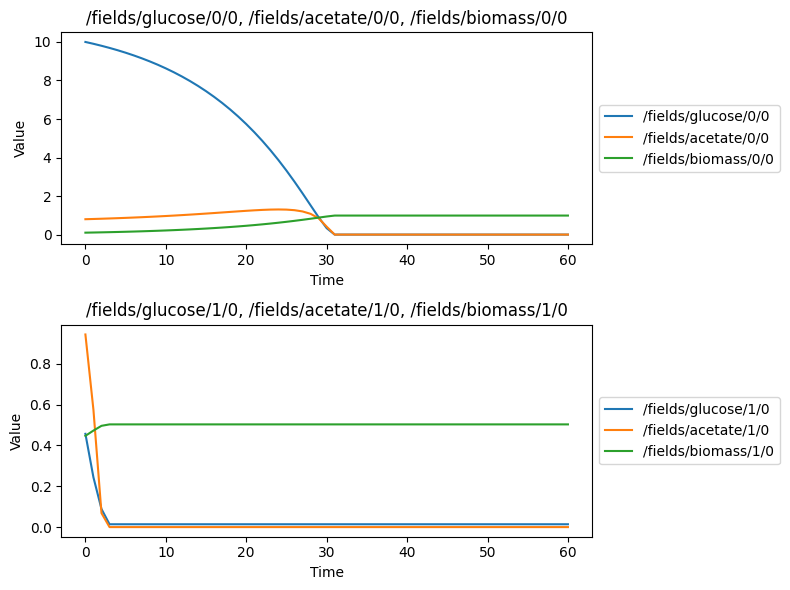

In [44]:
v2.plot_timeseries(
    subplot_size=(8, 3),
    combined_vars=all_paths
)